# Course Project - Computational Finance (CS 515)

> This python code was developed as a part of Computational Finance Course (CS 515) during the Fall Semester of 2024. This project focuses on implementing and analyzing various financial option pricing models.  The project includes the following key components:
>
>   1. Data Collection: </br>
    Using the `yfinance` library to fetch historical stock data for Reliance.NS. </br>
>
>   2. Calculation of Historical Volatility: </br>
    Calculating the volatility using `Standard Deviation`, `Parkinson`, `Garman Klass` and `EWMA`. </br>
>
>   3. Black-Scholes Model: </br>
    Implementation of the Black-Scholes formula for pricing European options. </br>
    Analytical approach using continuous time and log-normal distribution of stock prices. </br>
>    
>   4. Binomial Model: </br>
    mplementation of the Binomial model for pricing European options. </br>
    Discrete time approach using a binomial tree to model the possible future stock prices. </br>

### Installing necessary packages

In [1]:
!pip install -r requirements.txt --quiet


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


### Importing the necessary libraries

In [2]:
import yfinance as yf
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from IPython.display import display, HTML

### Global Variables


In [3]:
ticker = "RELIANCE.NS"  # Stock
K = 2600                # Strike price for option
T = 0.0167                 # Time to expiration in years of option (e.g., 6 months)
r = 0.06                # Risk-free interest rate (annualized)
sigma = 0.22            # Volatility of the stock
steps = 100             # Number of steps in the binomial tree

### Fetching stock price data via Yahoo Finance API

In [4]:
reliance_stock = yf.Ticker(ticker)
df=reliance_stock.history(interval="1d", period="1y")
stock_price = df['Close'].iloc[-1]
print(f"Current stock price for Reliance: {stock_price}")

Current stock price for Reliance: 2655.699951171875


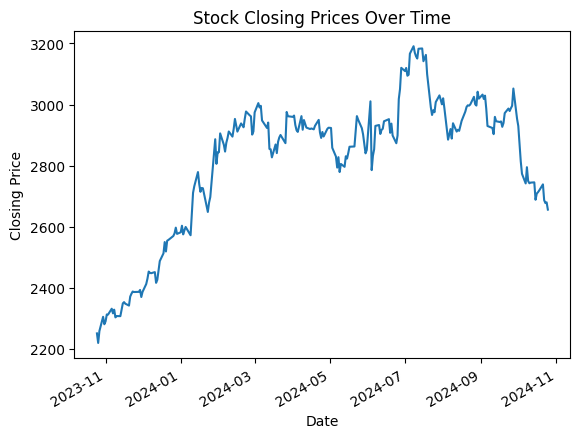

In [5]:
# Plot of "Close" data of Reliance.NS Stock

df['Close'].plot()
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Stock Closing Prices Over Time")
plt.show()

## Calculating Historical Volatility

### Standard Deviation
---

>   Calculates the historical volatility of a financial instrument using the standard deviation of log returns.
    This function computes the standard deviation of log returns over a specified window of trading periods,
    adjusted by the annualization factor `trading_periods`, which defaults to 252 (the approximate number of 
    trading days in a year). The historical volatility is most often used to estimate future volatility and
    is calculated using the sample standard deviation, dividing by (n - 1).

#### Formula:
---
> In our calculation, we first compute the log returns for the last \( n \) observations, where \( n \) is defined by the `window` parameter:
> $$
> r_i = \ln \left( \frac{S_i}{S_{i-1}} \right)
> $$
> where \( S_i \) is the current price and \( S_{i-1} \) is the previous price.

> The standard deviation of these log returns is then calculated using the formula:
> $$
> \text{Standard Deviation} = \sqrt{\frac{1}{n-1} \sum_{i=1}^{n} (r_i - \bar{r})^2}
> $$
> where \( \bar{r} \) is the mean of the log returns.

> Finally, to annualize the standard deviation, we multiply by the square root of the number of trading periods per year (typically 252):
> $$
> \text{Annualized Volatility} = \text{Standard Deviation} \times \sqrt{T}
> $$
> where \( T \) is the number of trading periods (252).

#### Notes:
---
>   - The log return, xi, in a volatility calculation represents the logarithmic price change between successive days. <br>
>   - This calculation assumes daily returns based on one day’s price change to the next.





In [6]:
def standard_deviation(price_data, window=30, trading_periods=252):
    """
    Parameters:
    -----------
    price_data : pandas.DataFrame
        DataFrame containing at least a 'Close' column with daily closing prices.
    window : int, optional, default=30
        The number of days over which to calculate the log returns and volatility.
    trading_periods : int, optional, default=252
        The annualization factor, typically set to the number of trading days in a year (252).

    Returns:
    --------
    float
        The annualized standard deviation of log returns, representing historical volatility.
    """

    # Calculate log returns for the last 'window' number of data points
    log_return = (price_data["Close"].iloc[-window:] / price_data["Close"].shift(1).iloc[-window:]).apply(np.log)

    # Calculate the standard deviation of the log returns
    std_dev = log_return.std(ddof=1) * math.sqrt(trading_periods)

    return std_dev

def average_std_volatility(volatility_func, df, windows=range(14, 211, 7)):
    std_devs = [volatility_func(df, window) for window in windows]
    return np.mean(std_devs)
    
print(f"Average Annualized Volatility from standard deviation: {average_std_volatility(standard_deviation, df)}")

Average Annualized Volatility from standard deviation: 0.21775111202385433


### Parkinson
---

>   Calculates the annualized historical volatility of a financial instrument using the Parkinson extreme-value method. <br>
>   This function estimates volatility by analyzing the high and low prices within a specific window, capturing a
    more comprehensive view of volatility. The extreme-value method, proposed by Michael Parkinson, is particularly
    useful when daily settlement prices are unavailable, as it relies on daily high and low prices. The annualized
    volatility is calculated by applying a scaling factor derived from the distribution of extreme values, adjusted
    by the annualization factor `trading_periods`.

---
#### Use Case
> Suppose that the price of a contract fluctuates wildly during a trading day,
making dramatic up and down moves, yet finishes the day unchanged. If this is
a common occurrence, then using only settlement prices to calculate the histor-
ical volatility may result in an incomplete picture of a contract’s true volatility.
To take into consideration intraday price movement, several alternative meth-
ods have been proposed to calculate historical volatility

#### Formula:
---

> The Parkinson volatility is calculated using the formula:
> $$
> r_s = \frac{1}{4 \ln(2)} \left( \ln\left(\frac{H}{L}\right) \right)^2
> $$
> where:
> - \( H \) is the highest price over the period,
> - \( L \) is the lowest price over the period.

> The mean of these squared log returns is then annualized:
> $$
> \text{Annualized Volatility} = \sqrt{T \cdot \text{mean}(r_s)}
> $$
> where \( T \) is the number of trading periods (typically 252).

#### Notes:
---
>   - The extreme-value method is advantageous when daily closing prices are inconsistent or unavailable, using high and low prices to estimate a more accurate volatility. <br>
>   - Annualized volatility is derived from the mean of the log returns squared for high/low price ratios.

In [7]:
def parkinson(price_data, window=30, trading_periods=252):
    """
    Parameters:
    -----------
    price_data : pandas.DataFrame
        DataFrame containing at least 'High' and 'Low' columns with daily high and low prices.
    window : int, optional, default=30
        The number of days over which to calculate the Parkinson volatility.
    trading_periods : int, optional, default=252
        The annualization factor, typically set to the number of trading days in a year (252).

    Returns:
    --------
    float
        The annualized Parkinson historical volatility, representing the instrument's volatility based on extreme values.

    """
    # Calculate the Parkinson volatility for the last 'window' number of data points
    rs = (1.0 / (4.0 * math.log(2.0))) * (
        (price_data["High"].iloc[-window:] / price_data["Low"].iloc[-window:]).apply(np.log)
    ) ** 2.0

    # Calculate the mean of the rs values and then the volatility
    volatility = (trading_periods * rs.mean()) ** 0.5

    return volatility

print(f"Average Annualized Parkinson Volatility: {average_std_volatility(parkinson,df)}")

Average Annualized Parkinson Volatility: 0.18656036271990983


### Garman Klass
---

>   Calculates the annualized historical volatility of a financial instrument using the Garman-Klass method. <br>
>   The Garman-Klass volatility estimator uses both the high-low and open-close prices within a specified window
    to calculate volatility, offering improved accuracy over methods that rely solely on closing prices. This
    method assumes that price movements follow a geometric Brownian motion, capturing both overnight price jumps
    and intra-day price fluctuations. The result is annualized based on a specified number of trading periods.
Here’s the Markdown description for the Garman-Klass volatility calculation:

#### Formula:
---

> The Garman-Klass volatility is calculated using the following formula:
> $$
> r_s = 0.5 \cdot \left( \ln\left(\frac{H}{L}\right) \right)^2 - (2 \ln(2) - 1) \cdot \left( \ln\left(\frac{C}{O}\right) \right)^2
> $$
> where:
> - \( H \) is the highest price,
> - \( L \) is the lowest price,
> - \( C \) is the closing price,
> - \( O \) is the opening price.

> The mean of these calculated values is then annualized:
> $$
> \text{Annualized Volatility} = \sqrt{T \cdot \text{mean}(r_s)}
> $$
> where \( T \) is the number of trading periods (typically 252).

---

#### Notes:
---
>   - his method captures volatility using both the range (high-low) and the open-close price movements,
      increasing robustness over the close-only estimators. <br>
>   - The volatility estimate is annualized based on the mean of the calculated range over the specified window.

In [8]:
def garman_klass(price_data, window=250, trading_periods=252):
    """
    Parameters:
    -----------
    price_data : pandas.DataFrame
        DataFrame containing 'High', 'Low', 'Open', and 'Close' columns with daily high, low, open, and close prices.
    window : int, optional, default=30
        The number of days over which to calculate the Garman-Klass volatility.
    trading_periods : int, optional, default=252
        The annualization factor, typically set to the number of trading days in a year (252).

    Returns:
    --------
    float
        The annualized Garman-Klass historical volatility, representing the instrument's volatility based on high-low
        and open-close prices.
    """

    # Calculate log values for the last 'window' number of data points
    log_hl = (price_data["High"].iloc[-window:] / price_data["Low"].iloc[-window:]).apply(np.log)
    log_co = (price_data["Close"].iloc[-window:] / price_data["Open"].iloc[-window:]).apply(np.log)

    rs = 0.5 * log_hl ** 2 - (2 * math.log(2) - 1) * log_co ** 2

    # Calculate the mean of the rs values and then the volatility
    volatility = (trading_periods * rs.mean()) ** 0.5

    return volatility

print(f"Average Annualized Garman-Klass Volatility: {average_std_volatility(garman_klass,df)}")

Average Annualized Garman-Klass Volatility: 0.18507116029741846


### EWMA (Exponentially Weighted Moving Average)

> Exponentially weighted moving averages (EWMA) add more weight to recent observations. By incorporating a smoothing factor $\lambda$, that dictates the rate at which past data diminishes in relevance, the model can be tailored to reflect the desired responsiveness to recent market movements. The higher the $\lambda$, the more weight is attributed to past returns when computing volatility.

---

> We calculate the squared log-returns using:
> $$
r_i = \left ( \ln \frac{S_i}{S_{i-1}} \right)^2
$$
> The EWMA volatility is computed using the formula:
> $$
\text{EWMA}t = (1 - \lambda)* r_t + \lambda*\text{EWMA}{t-1}
$$

---

#### Notes:
---
>   Common value of lambda used is 0.94

In [9]:
def ewma_volatility(price_data, lamda = 0.94, trading_periods=252):
    """
        Parameters:
        -----------
        price_data : pandas.DataFrame
            Historical data of stock prices
        lambda : float, optional, default = 0.94
            smoothing parameter
        trading_periods : int, optional, default = 252
            The annualization factor, typically set to the number of trading days in a year 

        Returns:
        --------
        float
            The calculated volatility of the stock
    """
    # Calculate log returns
    log_returns = np.log(price_data['Close']/price_data['Close'].shift(1))[1:]
    sq_rets_sp500 = (log_returns**2).values
    EWMA_var = np.zeros(len(sq_rets_sp500))
    # Calculate EWMA volatility
    for r in range(1, len(sq_rets_sp500)):
        EWMA_var[r] = (1-lamda)*sq_rets_sp500[r] + lamda*EWMA_var[r-1]
    
    return np.sqrt(EWMA_var[-1]*trading_periods)

print(f"Average Annualized Volatility (EWMA Method): {ewma_volatility(df)}")

Average Annualized Volatility (EWMA Method): 0.20062210492851534


### **Black-Scholes Option Pricing**

> The Black-Scholes model is a mathematical model used to calculate the theoretical price of European call and put options. It relies on several key variables, including the current stock price, strike price, time to expiration, risk-free interest rate, and volatility. This model assumes that the price of the underlying asset follows a geometric Brownian motion, which allows for continuous price changes.

#### Formula:
---

> The price of a European call option is calculated using the following formulas:
> 
> $$
> d_1 = \frac{\ln\left(\frac{S}{K}\right) + \left(r + \frac{1}{2} \sigma^2\right) T}{\sigma \sqrt{T}}
> $$
> $$
> d_2 = d_1 - \sigma \sqrt{T}
> $$
> 
> The call option price is then computed as:
> 
> $$
> C = S \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2)
> $$
> 
> The price of a European put option is calculated using:
> 
> $$
> P = K \cdot e^{-rT} \cdot N(-d_2) - S \cdot N(-d_1)
> $$
> 
> where:
> - \( C \) is the call option price,
> - \( P \) is the put option price,
> - \( S \) is the current stock price,
> - \( K \) is the strike price,
> - \( T \) is the time to maturity (in years),
> - \( r \) is the risk-free interest rate (annual),
> - \( \sigma \) is the volatility of the stock (annual),
> - \( N(d) \) is the cumulative distribution function of the standard normal distribution.

In [10]:
# Black-Scholes formula for a European Option
def black_scholes(S, K, T, r, sigma):
    """
    Parameters:
    -----------
    S : float
        Current stock price.
    K : float
        Strike price of the option.
    T : float
        Time to maturity in years.
    r : float
        Annual risk-free interest rate.
    sigma : float
        Annual volatility of the stock.

    Returns:
    --------
    float
        The calculated price of the European call and put option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
    return call_price,put_price

call_price_bs, put_price_bs = black_scholes(stock_price, K, T, r, sigma)
print(f"Call option price using Black-Scholes: {call_price_bs}")
print(f"Put option price using Black-Scholes: {put_price_bs}")

Call option price using Black-Scholes: 67.58650457922136
Put option price using Black-Scholes: 9.28265817671695


### **Binomial Option Pricing Model**
---
> The Binomial Option Pricing Model is a discrete-time model used to evaluate options by simulating different possible future paths that the price of an underlying asset can take. It represents time as a series of discrete steps where the asset price can either move up or down, and it calculates the value of the option by stepping backward through the tree. This model is widely used for American options due to its flexibility in handling early exercise.

#### Formula:
---

> In this approach, the call option price is calculated by:
>
> - Dividing the time to maturity \( T \) into a given number of steps \( \text{steps} \).
> - Defining up and down factors based on the volatility \( sigma \) and time step \( dt \):
>   $$
>   u = e^{\sigma \sqrt{dt}}, \quad d = \frac{1}{u}
>   $$
> - Determining the risk-neutral probability of an upward movement \( q \):
>   $$
>   q = \frac{e^{r dt} - d}{u - d}
>   $$
> - Simulating possible asset prices and option values at maturity and discounting back through the tree:
>   $$
>   \text{Option Value at step} = e^{-r dt} \cdot \left[q \cdot \text{Option Value up} + (1 - q) \cdot \text{Option Value down}\right]
>   $$

In [11]:
# Binomial option pricing model
def binomial_option_prices(S, K, T, r, sigma, steps):
    """
    Parameters:
    -----------
    S : float
        Current stock price.
    K : float
        Strike price of the option.
    T : float
        Time to maturity in years.
    r : float
        Annual risk-free interest rate.
    sigma : float
        Annual volatility of the stock.
    N : int
        Number of time steps in the binomial model.

    Returns:
    --------
    float
        The calculated price of the European call and put option.
    """
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))    # Up factor
    d = 1 / u                          # Down factor
    q = (np.exp(r * dt) - d) / (u - d) # Risk-neutral probability
    discount_factor = np.exp(-r * dt)  # Discount factor for each step

    # Initialize option values at maturity
    option_values = np.maximum(0, S * u**np.arange(steps, -1, -1) * d**np.arange(0, steps + 1) - K)
    put_values = np.maximum(0, K - S * u**np.arange(steps, -1, -1) * d**np.arange(0, steps + 1))

    # Step back through the tree
    for step in range(steps - 1, -1, -1):
        option_values = discount_factor * (q * option_values[:-1] + (1 - q) * option_values[1:])
        put_values = discount_factor * (q * put_values[:-1] + (1 - q) * put_values[1:])

    return option_values[0], put_values[0]

call_price_binomial, put_price_binomial = binomial_option_prices(stock_price, K, T, r, sigma, steps)
print(f"Call option price using Binomial model: {call_price_binomial}")
print(f"Put option price using Binomial model: {put_price_binomial}")

Call option price using Binomial model: 67.6114296823471
Put option price using Binomial model: 9.307583279819982


### Generating a graph
---

The graph below compares option prices predicted by the Black-Scholes model, a continuous-time model, and the Binomial model, a discrete-time model. The Black-Scholes model assumes a continuous geometric Brownian motion for the underlying asset, which leads to a closed-form solution for European option pricing.

In contrast, the Binomial model divides the time to expiration into a finite number of discrete time steps, at each of which the underlying asset can move up or down by a specified factor. As the number of steps in the Binomial model increases, the model’s approximation improves, and the option price it predicts begins to converge toward the continuous-time Black-Scholes price. This convergence occurs because the discrete Binomial model approximates the continuous distribution of possible asset prices more closely with a greater number of steps, thus aligning with the theoretical assumptions of the Black-Scholes model.


---

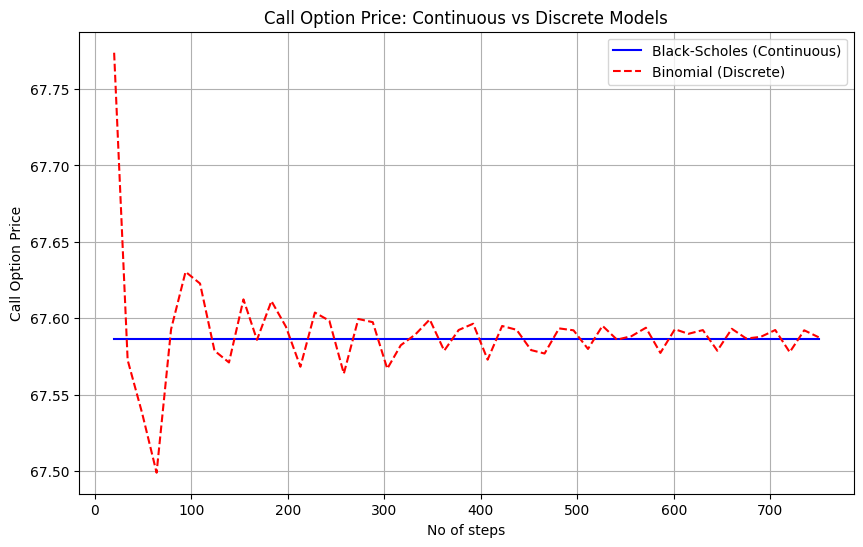

In [12]:
# Generate a graph
time_steps = np.linspace(20, 750, 50,dtype = int)

# Arrays to store Black-Scholes and binomial option prices at different time points
call_prices_bs = []
call_prices_binomial = []
put_prices_bs = []
put_prices_binomial = []


# Calculate call option prices at each time step
for steps in time_steps:
    call_prices_bs.append(black_scholes(stock_price, K, T, r, sigma)[0])
    call_prices_binomial.append(binomial_option_prices(stock_price, K, T, r, sigma, steps)[0])

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(time_steps, call_prices_bs, label="Black-Scholes (Continuous)", color='blue')
plt.plot(time_steps, call_prices_binomial, label="Binomial (Discrete)", color='red', linestyle='--')

plt.title("Call Option Price: Continuous vs Discrete Models")
plt.xlabel("No of steps")
plt.ylabel("Call Option Price")
plt.legend()
plt.grid(True)
plt.show()

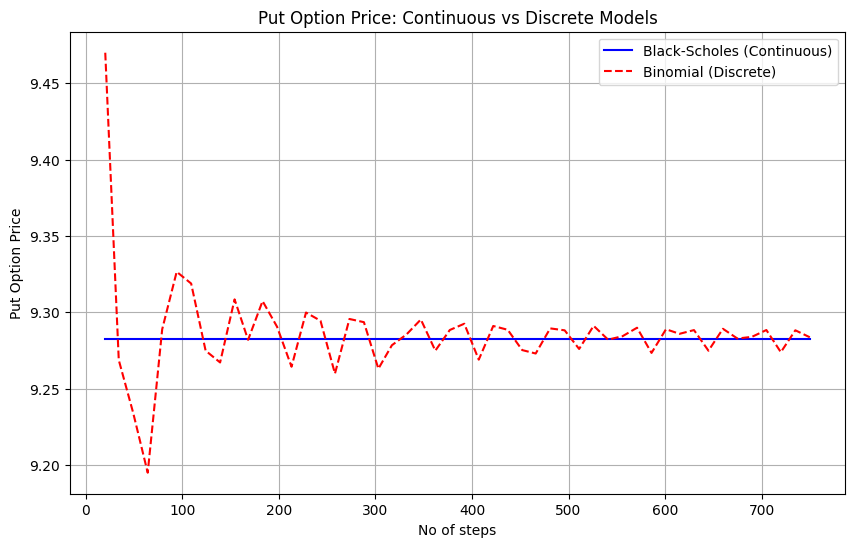

In [13]:
# Calculate call option prices at each time step
for steps in time_steps:
    put_prices_bs.append(black_scholes(stock_price, K, T, r, sigma)[1])
    put_prices_binomial.append(binomial_option_prices(stock_price, K, T, r, sigma, steps)[1])

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(time_steps, put_prices_bs, label="Black-Scholes (Continuous)", color='blue')
plt.plot(time_steps, put_prices_binomial, label="Binomial (Discrete)", color='red', linestyle='--')

plt.title("Put Option Price: Continuous vs Discrete Models")
plt.xlabel("No of steps")
plt.ylabel("Put Option Price")
plt.legend()
plt.grid(True)
plt.show()

## Analysis

As can be seen from the option-chain of 25th Oct 2024 for reliance options with expiry date of 31st october implied volatility for the at the money options is approximately in the range of 21 to 23, and the volatility predicted by us using standard deviation method is around Average Annualized Volatility from standard deviation: 0.21775111202385433 and Average Annualized Parkinson Volatility: 0.18656036271990983, Average Annualized Garman-Klass Volatility: 0.18507116029741846, Average Annualized Volatility (EWMA Method): 0.20062210492851534

In [14]:
# Function to calculate predicted volatility using different methods
def calculate_predicted_volatility(method, df):
    if method == "ewma": return ewma_volatility(df)
    return average_std_volatility(globals()[method],df)

# Function to calculate Black-Scholes and Binomial option prices
def calculate_option_prices(option_type, stock_price, strike, T, r, volatility, steps):
    if option_type == "call":
        call_price_bs, _ = black_scholes(stock_price, strike, T, r, volatility)
        call_price_binomial, _ = binomial_option_prices(stock_price, strike, T, r, volatility, steps)
        return call_price_bs, call_price_binomial
    elif option_type == "put":
        _, put_price_bs = black_scholes(stock_price, strike, T, r, volatility)
        _, put_price_binomial = binomial_option_prices(stock_price, strike, T, r, volatility, steps)
        return put_price_bs, put_price_binomial

# Main function to compute option prices and volatilities
def compute_option_data(option_type, stock_price, strike_prices, actual_prices, implied_volatilities, T, r, steps, df):
    methods = []
    black_scholes_prices = []
    binomial_model_prices = []
    predicted_volatilities = []
    
    for strike in [strike_prices[i] for i in range(0,len(strike_prices),4)]:
        for method in ["standard_deviation", "parkinson", "garman_klass", "ewma"]:
            methods.append(method)
            volatility = calculate_predicted_volatility(method, df)
            predicted_volatilities.append(volatility)
            
            bs_price, binomial_price = calculate_option_prices(option_type, stock_price, strike, T, r, volatility, steps)
            black_scholes_prices.append(bs_price)
            binomial_model_prices.append(binomial_price)
    
    return {
        "method": methods,
        "strike_prices": strike_prices,
        "black_scholes_prices": black_scholes_prices,
        "binomial_model_prices": binomial_model_prices,
        "actual_prices": actual_prices,
        "predicted_volatilities": predicted_volatilities,
        "implied_volatilities": implied_volatilities
    }

# Function to neatly print option data
def print_option_data(data, option_type):
    df = pd.DataFrame({
        "Method": data["method"],
        "Strike Price": data["strike_prices"],
        "Actual Price": data["actual_prices"],
        "Implied Volatility": data["implied_volatilities"],
        "Predicted Volatility": data["predicted_volatilities"],
        "Black-Scholes Price": data["black_scholes_prices"],
        "Binomial Model Price": data["binomial_model_prices"]
    })
    
    print(f"\n{option_type.capitalize()} Option Data:\n")
    # print(df.to_string(index=False))
    display(HTML(df.to_html(index=False)))



call_data = {
    "actual_prices": [28.45] * 4 + [20.50] * 4 + [68.025] * 4,
    "implied_volatilities": [0.2111] * 4 + [0.2180] * 4 + [0.2234] * 4,
    "strike_prices": [2660] * 4 + [2680] * 4 + [2600] * 4
}
put_data = {
    "actual_prices": [31.825] * 4 + [43.475] * 4,
    "implied_volatilities": [0.2285] * 4 + [0.2344] * 4,
    "strike_prices": [2660] * 4 + [2680] * 4 
}

# Compute Call and Put Option Data
call_option_data = compute_option_data("call", stock_price, call_data["strike_prices"], call_data["actual_prices"], call_data["implied_volatilities"], T, r, steps, df)
put_option_data = compute_option_data("put", stock_price, put_data["strike_prices"], put_data["actual_prices"], put_data["implied_volatilities"], T, r, steps, df)

# Outputs
print_option_data(call_option_data, "call")
print_option_data(put_option_data, "put")


Call Option Data:



Method,Strike Price,Actual Price,Implied Volatility,Predicted Volatility,Black-Scholes Price,Binomial Model Price
standard_deviation,2660,28.450,0.2111,0.217751,29.010447,29.013790
parkinson,2660,28.450,0.2111,0.186560,24.740246,24.736767
garman_klass,2660,28.450,0.2111,0.185071,24.536372,24.532499
ewma,2660,28.450,0.2111,0.200622,26.665351,26.665265
standard_deviation,2680,20.500,0.2180,0.217751,20.358968,20.367753
parkinson,2680,20.500,0.2180,0.186560,16.274214,16.274864
garman_klass,2680,20.500,0.2180,0.185071,16.080847,16.083113
ewma,2680,20.500,0.2180,0.200622,18.108147,18.109736
standard_deviation,2600,68.025,0.2234,0.217751,67.362738,67.366628
parkinson,2600,68.025,0.2234,0.186560,64.424327,64.419142



Put Option Data:



Method,Strike Price,Actual Price,Implied Volatility,Predicted Volatility,Black-Scholes Price,Binomial Model Price
standard_deviation,2660,31.825,0.2285,0.217751,30.646511,30.649854
parkinson,2660,31.825,0.2285,0.186560,26.376310,26.372831
garman_klass,2660,31.825,0.2285,0.185071,26.172436,26.168562
ewma,2660,31.825,0.2285,0.200622,28.301415,28.301329
standard_deviation,2680,43.475,0.2344,0.217751,41.975002,41.983786
parkinson,2680,43.475,0.2344,0.186560,37.890247,37.890897
garman_klass,2680,43.475,0.2344,0.185071,37.696881,37.699147
ewma,2680,43.475,0.2344,0.200622,39.724181,39.725770
